# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [ ]:
! pip install SimpleITK 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 31.0 MB/s eta 0:00:00


### Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip

--2023-03-02 12:26:37--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  30.0MB/s    in 15s     

2023-03-02 12:26:54 (29.0 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating: data

### Setting data directory

In [ ]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

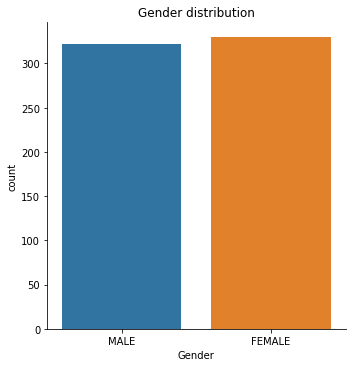

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


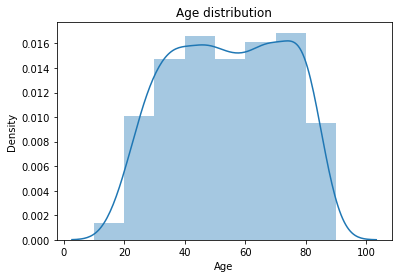

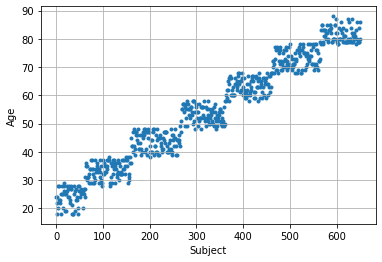

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


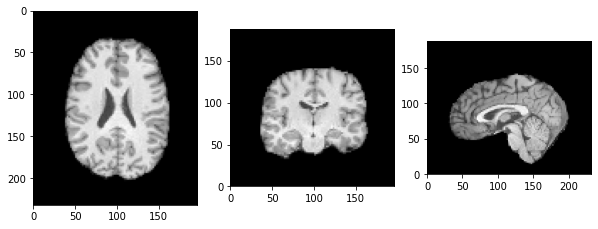

Brain mask


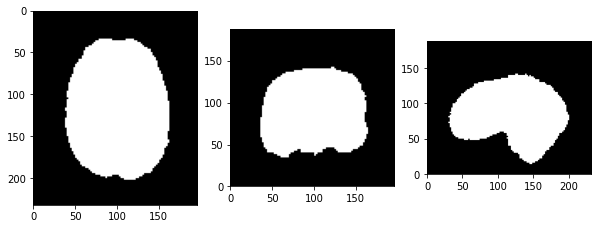

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: NVIDIA A100-SXM4-40GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [ ]:
rnd_seed = 42

img_size = [128, 128, 128]
img_spacing = [1.5, 1.5, 1.5]

num_epochs = 30
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [ ]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


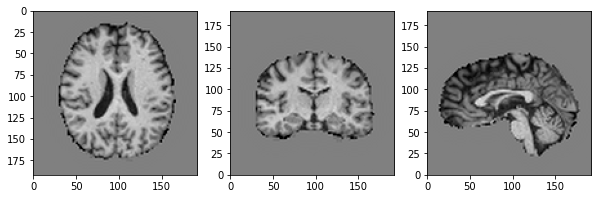

Segmentation


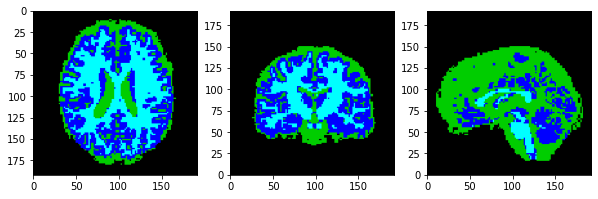

Mask


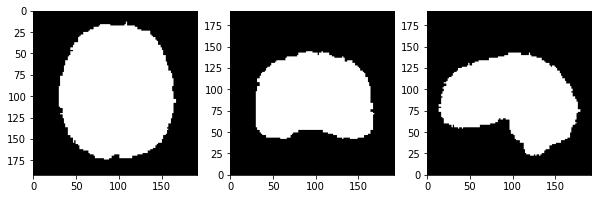

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [ ]:

########################################
# BUILD A BETTER MODEL HERE
########################################

class UNet(nn.Module):

    def __init__(self, in_channels=1, num_classes=4):
        super(UNet, self).__init__()

        self.encoder1 = UNet.block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = UNet.block(32, 64)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder3 = UNet.block(64, 128)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder4 = UNet.block(128, 256)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.bottleneck = UNet.block(256, 512)

        self.upconv4 = nn.ConvTranspose3d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = UNet.block(512, 256)
        self.upconv3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = UNet.block(256, 128)
        self.upconv2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = UNet.block(128, 64)
        self.upconv1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = UNet.block(64, 32)
        self.conv = nn.Conv3d(in_channels=32, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))
    
    def block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm3d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm3d(out_channels),
          nn.ReLU(inplace=True)
      )

class SimpleNet3D(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)
    
    def forward(self, x):
        #print("Shape before conv1", x.shape)
        x = F.relu(self.conv1(x))
        #print("Shape after conv1", x.shape)
        x = self.conv2(x)
        #print("Shape after conv2", x.shape)
        #print("")
        return x # cross-entropy loss expects raw logits and applies softmax


In [ ]:
def dice_loss_3D_seg(ground_truth, prediction, eps=1e-7):
    """Computes the Dice-similarity between a ground_truth and predicted segmentation.

    Args:
        ground_truth (torch.tensor shape [B, 1, H, W]): The ground truth segmentation.
        prediction: (torch.tensor shape [B, C, H, W]): Model prediction.
        eps: small number used for numerical stability.

    Returns:
        dice_loss
    """

    ground_truth_1_hot = torch.eye(num_classes)[ground_truth.squeeze(1)]
    ground_truth_1_hot = ground_truth_1_hot.permute(0, 4, 1, 2, 3).float()
    prediction_compact = torch.argmax(prediction, dim=1) 
    probabilities = F.softmax(prediction, dim=1)
    prediction_compact = torch.argmax(probabilities, dim=1)
    prediction_1_hot = torch.eye(num_classes)[prediction_compact.squeeze(1)]
    prediction_1_hot = prediction_1_hot.permute(0, 4, 1, 2, 3).float()
    prediction_1_hot = prediction_1_hot.type(prediction.type())
    ground_truth_1_hot = ground_truth_1_hot.type(prediction.type())

    dims = (0,) + tuple(range(2, ground_truth.ndimension()))
    intersection = torch.sum(prediction_1_hot * ground_truth_1_hot, dims)
    cardinality = torch.sum(prediction_1_hot + ground_truth_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()

    return dice_loss

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 1.136708
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 1.140910


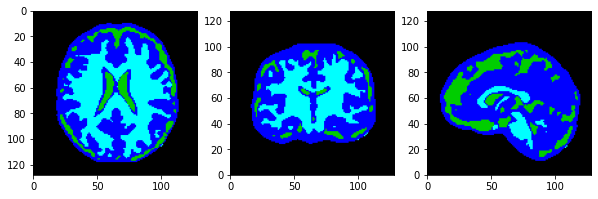

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 1.057252
+ TRAINING 	Epoch: 3 	Loss: 1.002029
+ TRAINING 	Epoch: 4 	Loss: 0.950116
+ TRAINING 	Epoch: 5 	Loss: 0.901996
+ TRAINING 	Epoch: 6 	Loss: 0.876047
+ TRAINING 	Epoch: 7 	Loss: 0.860071
+ TRAINING 	Epoch: 8 	Loss: 0.838526
+ TRAINING 	Epoch: 9 	Loss: 0.825499
+ TRAINING 	Epoch: 10 	Loss: 0.817046
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.817605


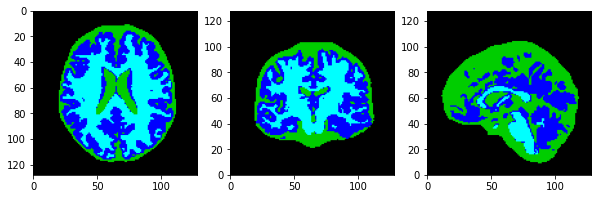

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.807945
+ TRAINING 	Epoch: 12 	Loss: 0.803062
+ TRAINING 	Epoch: 13 	Loss: 0.800173
+ TRAINING 	Epoch: 14 	Loss: 0.802632
+ TRAINING 	Epoch: 15 	Loss: 0.792690
+ TRAINING 	Epoch: 16 	Loss: 0.786864
+ TRAINING 	Epoch: 17 	Loss: 0.786054
+ TRAINING 	Epoch: 18 	Loss: 0.782720
+ TRAINING 	Epoch: 19 	Loss: 0.787800
+ TRAINING 	Epoch: 20 	Loss: 0.779558
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.781813


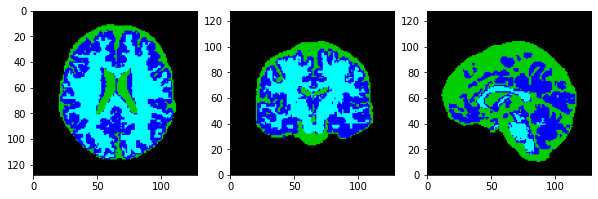

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.778466
+ TRAINING 	Epoch: 22 	Loss: 0.783394
+ TRAINING 	Epoch: 23 	Loss: 0.799701
+ TRAINING 	Epoch: 24 	Loss: 0.771010
+ TRAINING 	Epoch: 25 	Loss: 0.783322
+ TRAINING 	Epoch: 26 	Loss: 0.779863
+ TRAINING 	Epoch: 27 	Loss: 0.776422
+ TRAINING 	Epoch: 28 	Loss: 0.771721
+ TRAINING 	Epoch: 29 	Loss: 0.769139
+ TRAINING 	Epoch: 30 	Loss: 0.775454
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.774153


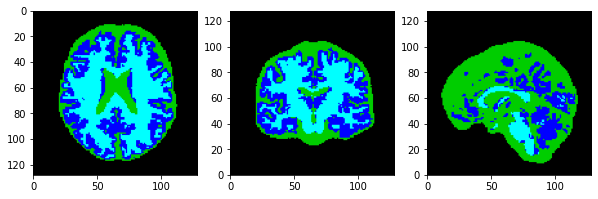

--------------------------------------------------

Finished TRAINING.


In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet().to(device)
#model = SimpleNet3D(num_classes).to(device)
model.train()
    
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
mse_val_log = []
epoch_val_log = []
dice_score_train_log = []
dice_score_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    sum_loss = 0
    dice_score = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        #print("prd shape", prd.shape)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()
        #dice_score += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        sum_loss += loss

    #avg_dice_score = dice_score / (batch_idx+1)
    #dice_score_train_log.append(avg_dice_score.item())
    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        dice_score= 0
        num_samples = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                #dice_score += dice_loss_3D_seg(seg.cpu(), prd.cpu())
                num_samples += 1
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

        loss_val /= sum_pts
        #avg_dice_score= dice_score / (num_samples)
        #dice_score_val_log.append(avg_dice_score.item())
        mse_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')


"\nax[1].set_title('Dice Score')\nax[1].plot(range(1, num_epochs +1), dice_score_train_log, c='blueviolet', label = 'Training')\nax[1].plot(epoch_val_log, dice_score_val_log, c='seagreen', label = 'Validation')\nax[1].set_xlabel('Epoch', fontsize=10)\nax[1].set_ylabel('Dice Score', fontsize=10)\nax[1].legend()\n"

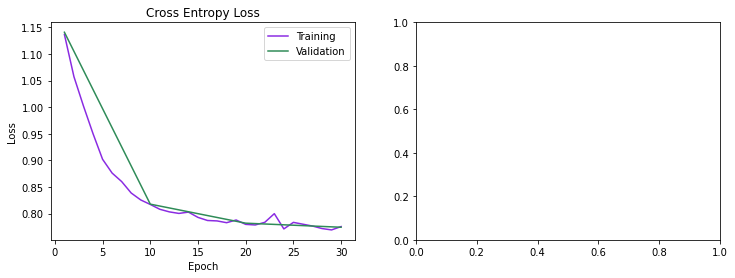

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title('Cross Entropy Loss', fontsize=12)
ax[0].plot(range(1, num_epochs + 1), loss_train_log, c='blueviolet', label='Training')
ax[0].plot(epoch_val_log, mse_val_log, c='seagreen', label='Validation')
ax[0].set_xlabel('Epoch', fontsize=10)
ax[0].set_ylabel('Loss', fontsize=10)
ax[0].legend()
# commented out for speed purposes. If you want to plot, uncomment dice calculation in previous cell
"""
ax[1].set_title('Dice Score')
ax[1].plot(range(1, num_epochs +1), dice_score_train_log, c='blueviolet', label = 'Training')
ax[1].plot(epoch_val_log, dice_score_val_log, c='seagreen', label = 'Validation')
ax[1].set_xlabel('Epoch', fontsize=10)
ax[1].set_ylabel('Dice Score', fontsize=10)
ax[1].legend()
"""

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:45<00:00,  4.73it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


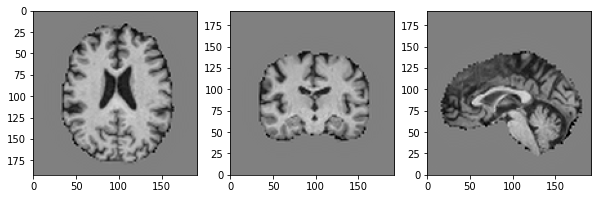

Segmentation


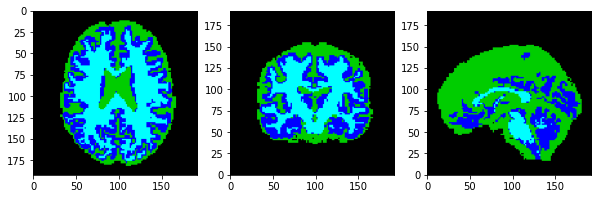

Mask


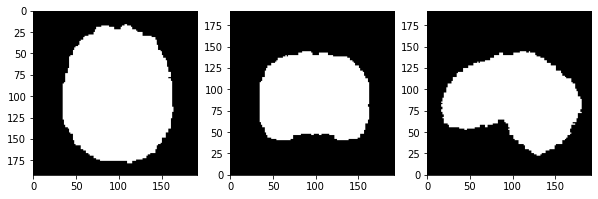

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.779027 	Dice Score: 0.902489


Reference segmentation


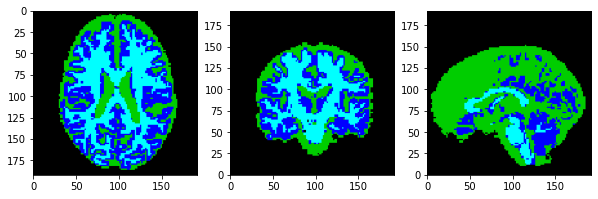

Predicted segmentation


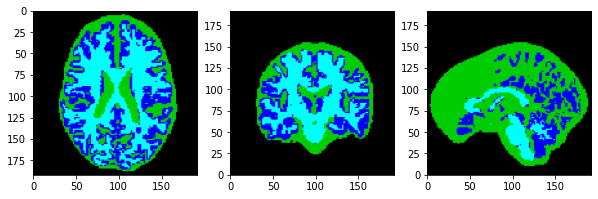


Finished TESTING.


In [ ]:
model_dir = os.path.join(out_dir, 'model')

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet()
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

dice_sc_WM_list = []
dice_score = 0
loss_test = 0
sum_pts = 0
idx_test = 0

CSF_DSCs = []
GM_DSCs = []
WM_DSCs = []

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)

        dice_score += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        prd = torch.argmax(prd, dim=1)

        # Metric calculation for each tissue
        overlap_measurer = sitk.LabelOverlapMeasuresImageFilter()
        for n, tissue_dice_score in enumerate([CSF_DSCs, GM_DSCs, WM_DSCs]):
                  
                  # Calculation of DSC for current tissue
                  segmentation_boolean = seg.cpu().squeeze().numpy().astype(np.uint8) == (n+1)
                  prediction_boolean = prd.cpu().squeeze().numpy().astype(np.uint8) == (n+1)
                  segmentation_tissue = segmentation_boolean.astype(int)
                  prediction_tissue = prediction_boolean.astype(int)
                  binary_segmentation_image = sitk.GetImageFromArray(segmentation_tissue)
                  binary_prediction_image = sitk.GetImageFromArray(prediction_tissue)

                  # Saving the DSC
                  overlap_measurer.Execute(binary_segmentation_image, binary_prediction_image)
                  dice_score_sample = overlap_measurer.GetDiceCoefficient()
                  tissue_dice_score.append(dice_score_sample)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice_score /= idx_test

print('+ TESTING \tLoss: {:.6f} \tDice Score: {:.6f}'.format(loss_test, dice_score))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

Text(0.5, 1.0, 'WM')

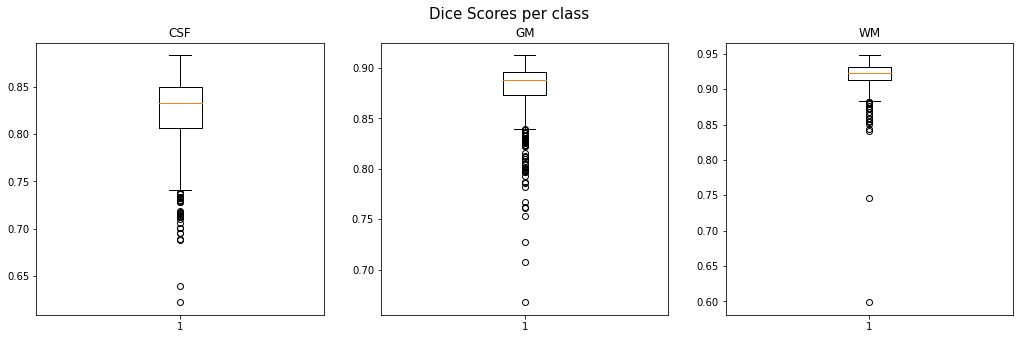

In [ ]:
# 600 DSCs for each tissue class in box-and-whisker-plots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17.5, 5))
f.suptitle('Dice Scores per class', fontsize=15)
ax1.boxplot(CSF_DSCs)
ax2.boxplot(GM_DSCs)
ax3.boxplot(WM_DSCs)
ax1.set_title('CSF')
ax2.set_title('GM')
ax3.set_title('WM')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))
vols_normalised = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################

        # calculate absolute volume of each tissue class
        background = np.sum(seg_array == 0) # 0 = background
        csf = np.sum(seg_array == 1) # 1 = csf
        gm = np.sum(seg_array == 2) # 2 = gm
        wm = np.sum(seg_array == 3) # 3 = wm

        # store absolute volumes in vols matrix
        vols[0, idx] = csf
        vols[1, idx] = gm
        vols[2, idx] = wm

        total_with_background = len(seg_array.flatten())
        total = np.sum(seg_array == 0)
        
        # storing relative volumes vols_normalised matrix
        vols_normalised[0, idx] = csf/(total_with_background-total)
        vols_normalised[1, idx] = gm/(total_with_background-total)
        vols_normalised[2, idx] = wm/(total_with_background-total)

       

Calculating Features: 100%|██████████| 500/500 [00:07<00:00, 63.65it/s]


Plot features versus age.

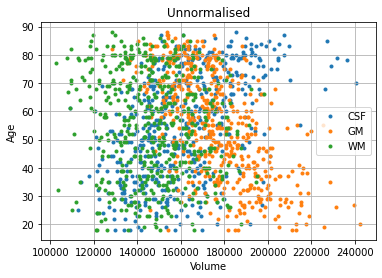

In [ ]:
plt.scatter(vols[0,:], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:], meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Plot normalised features versus age.

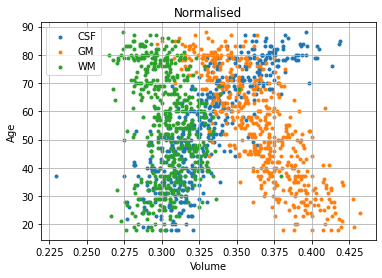

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn import svm

regs = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=0.1),
    'Lasso' : Lasso(alpha=0.1),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0),
    'KNeighborsRegressor' : KNeighborsRegressor(n_neighbors=2),
    'SVM': svm.SVR()
}

error_metrics = { 
    'mean_absolute_error' : mean_absolute_error, 
    'mean_squared_error' : mean_squared_error, 
    'r2_score' : r2_score,
}

number_models = len(regs)
number_errors = len(error_metrics)

# A matrix containg errros for each regressor
errors = np.zeros(shape=(number_models, number_errors))

# Lists containg predicted vs actual ages
k_folds_y_preds = []
k_folds_y_tests = []

# Perform 2-folds cross validation
k = 2
kf = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_preds = []
    for reg in regs.values():
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        y_pred = y_pred.reshape(X_train.shape[0],)
        y_preds.append(y_pred)
        
    for i in range(number_models):
        for j in range(number_errors):
            errors[i][j] += list(error_metrics.values())[j](y_test, y_preds[i])

    k_folds_y_preds.append(y_preds)
    k_folds_y_tests.append(y_test)

errors /= k
for i, regname in enumerate(regs.keys()):
    print(regname, "results")
    reg = list(regs.values())[i]
    reg_errors = errors[i]
    
    # Reporting error according to each metric
    for j, e in enumerate(error_metrics):
        print('{}: {}'.format(e, reg_errors[j]))
    print()

np_k_folds_y_preds = np.array(k_folds_y_preds)
np_k_folds_y_tests = np.array(k_folds_y_tests)
y_preds = np.concatenate((np_k_folds_y_preds[0], np_k_folds_y_preds[1]), axis=1)
y_tests = np.concatenate((np_k_folds_y_tests[0], np_k_folds_y_tests[1]), axis=0)
y_tests = y_tests.reshape(y_tests.shape[0],)


<ipython-input-60-c60f32e0d307>:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-60-c60f32e0d307>:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


LinearRegression results
mean_absolute_error: 8.04125
mean_squared_error: 102.96597070312501
r2_score: 0.6961393814789552

Ridge results
mean_absolute_error: 8.662826944427902
mean_squared_error: 114.95187956026656
r2_score: 0.6613486452004963

Lasso results
mean_absolute_error: 8.817825856019573
mean_squared_error: 118.41459693812862
r2_score: 0.6513237303594461

RandomForestRegressor results
mean_absolute_error: 7.5905442024659635
mean_squared_error: 95.33491013526483
r2_score: 0.7184120743112555

KNeighborsRegressor results
mean_absolute_error: 8.873999999999999
mean_squared_error: 123.194
r2_score: 0.6366001434107356

SVM results
mean_absolute_error: 8.021427255108797
mean_squared_error: 99.17007048431813
r2_score: 0.7077502813587098



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Error calculation and plotting

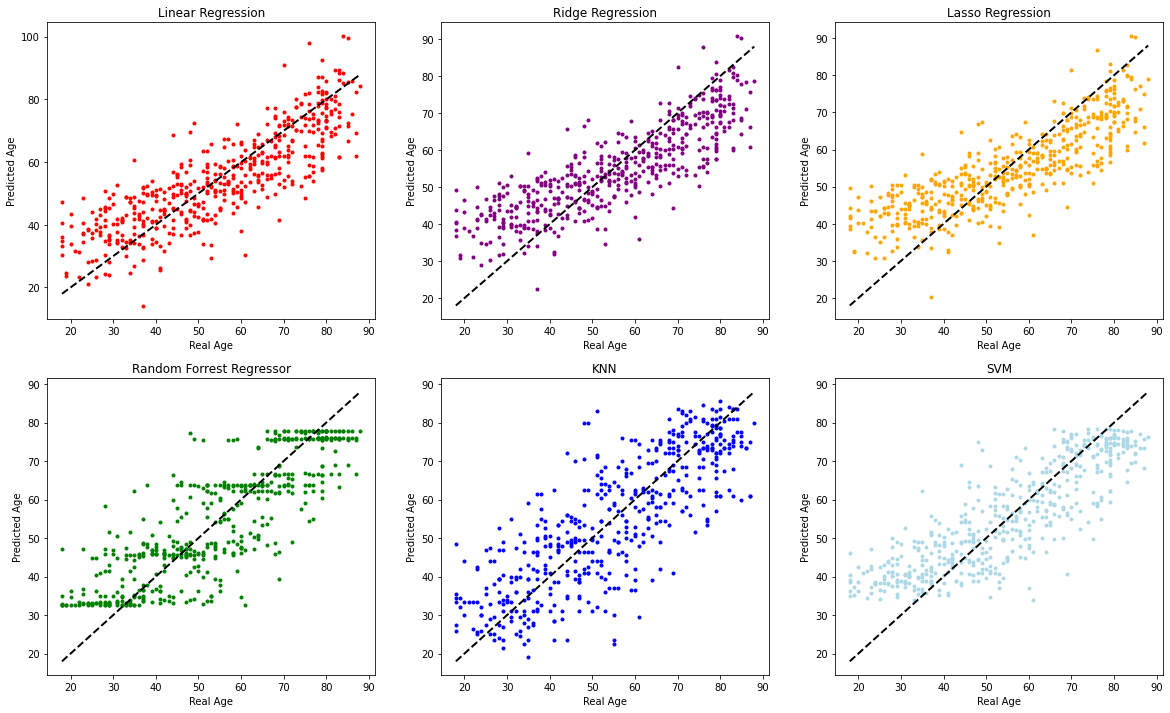

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20, 12))
ax[0,0].scatter(y_tests, y_preds[0], marker='.',color='red')
ax[0,0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[0,0].set_xlabel('Real Age')
ax[0,0].set_ylabel('Predicted Age')
ax[0,0].set_title("Linear Regression")

ax[0,1].scatter(y_tests, y_preds[1], marker='.', color='purple')
ax[0,1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[0,1].set_xlabel('Real Age')
ax[0,1].set_ylabel('Predicted Age')
ax[0,1].set_title("Ridge Regression")

ax[0,2].scatter(y_tests, y_preds[2], marker='.', color='orange')
ax[0,2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[0,2].set_xlabel('Real Age')
ax[0,2].set_ylabel('Predicted Age')
ax[0,2].set_title("Lasso Regression")

ax[1,0].scatter(y_tests, y_preds[3], marker='.', color='green')
ax[1,0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[1,0].set_xlabel('Real Age')
ax[1,0].set_ylabel('Predicted Age')
ax[1,0].set_title("Random Forrest Regressor")

ax[1,1].scatter(y_tests, y_preds[4], marker='.', color='blue')
ax[1,1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[1,1].set_xlabel('Real Age')
ax[1,1].set_ylabel('Predicted Age')
ax[1,1].set_title("KNN")

ax[1,2].scatter(y_tests, y_preds[5], marker='.', color='lightblue')
ax[1,2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax[1,2].set_xlabel('Real Age')
ax[1,2].set_ylabel('Predicted Age')
ax[1,2].set_title("SVM")

plt.show()

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-03-02 13:26:16--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-03-02 13:26:16 (371 MB/s) - ‘brainage-test-data.zip’ saved [1521/1521]

Archive:  brainage-test-data.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [ ]:
meta_data_reg_train_500 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test_500 = list(meta_data_reg_train_500['subject_id'])
files_seg_img_test_500 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_500]
files_seg_seg_test_500 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_500]
files_seg_msk_test_500 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_500]

dataset_test_500 = ImageSegmentationDataset(files_seg_img_test_500, files_seg_seg_test_500, files_seg_msk_test_500, img_spacing, img_size)
dataloader_test_500 = torch.utils.data.DataLoader(dataset_test_500, batch_size=batch_size, shuffle=False)


meta_data_reg_test_100 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test_100 = list(meta_data_reg_test_100['subject_id'])
files_seg_img_test_100 = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test_100]
files_seg_seg_test_100 = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_100]
files_seg_msk_test_100 = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test_100]

dataset_test_100 = ImageSegmentationDataset(files_seg_img_test_100, files_seg_seg_test_100, files_seg_msk_test_100, img_spacing, img_size)
dataloader_test_100 = torch.utils.data.DataLoader(dataset_test_100, batch_size=batch_size, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


#### Run final testing

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################
print("retraining the UNet model on the whole dataset (500 subjects)...")
num_epochs = 30

pred_dir = os.path.join(out_dir, 'pred')
model_dir = os.path.join(out_dir, 'unet_part_a')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)


model = UNet().to(device)
torch.manual_seed(rnd_seed) # fix random seed
model = UNet().to(device)
model.train()
    
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train_log = []
mse_val_log = []
epoch_val_log = []
# dice_score_train_log = []
# dice_score_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    sum_loss = 0
    dice_score = 0
    # Training
    for batch_idx, batch_samples in enumerate(dataloader_test_500):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        #print("prd shape", prd.shape)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()
        #dice_score += dice_loss_3D_seg(seg.cpu(), prd.cpu())
        sum_loss += loss

    # avg_dice_score = dice_score / (batch_idx+1)
    #dice_score_train_log.append(avg_dice_score.item())
    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f} \t'.format(epoch, loss.item()))
    
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')


retraining the UNet model on the whole dataset (500 subjects)...
START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.815914 	
+ TRAINING 	Epoch: 2 	Loss: 0.784048 	
+ TRAINING 	Epoch: 3 	Loss: 0.776806 	
+ TRAINING 	Epoch: 4 	Loss: 0.772902 	
+ TRAINING 	Epoch: 5 	Loss: 0.769817 	
+ TRAINING 	Epoch: 6 	Loss: 0.768248 	
+ TRAINING 	Epoch: 7 	Loss: 0.766977 	
+ TRAINING 	Epoch: 8 	Loss: 0.766294 	
+ TRAINING 	Epoch: 9 	Loss: 0.765726 	
+ TRAINING 	Epoch: 10 	Loss: 0.765315 	
+ TRAINING 	Epoch: 11 	Loss: 0.764632 	
+ TRAINING 	Epoch: 12 	Loss: 0.763734 	
+ TRAINING 	Epoch: 13 	Loss: 0.763110 	
+ TRAINING 	Epoch: 14 	Loss: 0.762637 	
+ TRAINING 	Epoch: 15 	Loss: 0.762091 	
+ TRAINING 	Epoch: 16 	Loss: 0.761788 	
+ TRAINING 	Epoch: 17 	Loss: 0.761798 	
+ TRAINING 	Epoch: 18 	Loss: 0.761807 	
+ TRAINING 	Epoch: 19 	Loss: 0.761299 	
+ TRAINING 	Epoch: 20 	Loss: 0.760774 	
+ TRAINING 	Epoch: 21 	Loss: 0.760744 	
+ TRAINING 	Epoch: 22 	Loss: 0.760608 	
+ TRAINING 	Epoch: 23 	Loss: 0.760606 	
+ TRAI

RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

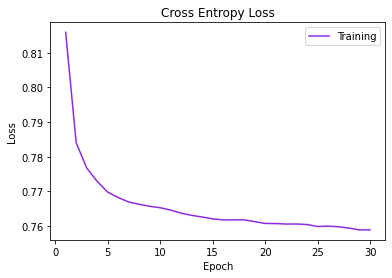

In [ ]:
plt.figure(figsize=(6, 4))

plt.title('Cross Entropy Loss', fontsize=12)
plt.plot(range(1, num_epochs + 1), loss_train_log, c='blueviolet', label='Training')
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend()

In [ ]:

model_dir = os.path.join(out_dir, 'unet_part_a')
model.load_state_dict(torch.load('output/unet_part_a/model.pt'))
model.to(device)
model.eval()

print('Apply trained model to the training (500) dataset')
# creating directory to save images
a_training_seg = os.path.join(out_dir, 'a_seg_train')
if not os.path.exists(a_training_seg):
    os.makedirs(a_training_seg)

dataloader_test_500 = torch.utils.data.DataLoader(dataset_test_500, batch_size=1, shuffle=False)

idx_test = 0
with torch.no_grad():
    # looping through the test dataset
    for sample_data in dataloader_test_500:
        # get the image and the segmentation
        img, seg, msk = sample_data['img'].to(device), sample_data['seg'].to(device), sample_data['msk'].to(device)
        # segmenting the image
        prd = model(img)
        prd = torch.argmax(prd, dim=1)

        # storing predicted segmentation
        sample = dataset_test_500.get_sample(idx_test)
        name = dataset_test_500.get_seg_name(idx_test)
    
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(a_training_seg, name))

        idx_test += 1  

print('Calculating tissue volumes from the training (500) dataset')
seg_dir = './output/a_seg_train/'

# extracting data
meta_data_reg_test_500 = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv') # meta data for the train dataset
ids_seg_test_500 = list(meta_data_reg_test_500['subject_id'])
files_reg_seg_test_500 = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_500]

# matricies to store volume data
vols = np.zeros((3,len(files_reg_seg_test_500)))
vols_normalised = np.zeros((3,len(files_reg_seg_test_500)))

# iterating through the segmented test dataset
# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_test_500)))
vols_normalised = np.zeros((3,len(files_reg_seg_test_500)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test_500)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test_500[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################

        # calculate absolute volume of each tissue class
        background = np.sum(seg_array == 0) # 0 = background
        csf = np.sum(seg_array == 1) # 1 = csf
        gm = np.sum(seg_array == 2) # 2 = gm
        wm = np.sum(seg_array == 3) # 3 = wm

        # store absolute volumes in vols matrix
        vols[0, idx] = csf
        vols[1, idx] = gm
        vols[2, idx] = wm

        total_with_background = len(seg_array.flatten())
        total = np.sum(seg_array == 0)
        
        # storing relative volumes vols_normalised matrix
        vols_normalised[0, idx] = csf/(total_with_background-total)
        vols_normalised[1, idx] = gm/(total_with_background-total)
        vols_normalised[2, idx] = wm/(total_with_background-total)
        

Apply trained model to the training (500) dataset
Calculating tissue volumes from the training (500) dataset


Calculating Features: 100%|██████████| 500/500 [00:07<00:00, 63.22it/s]


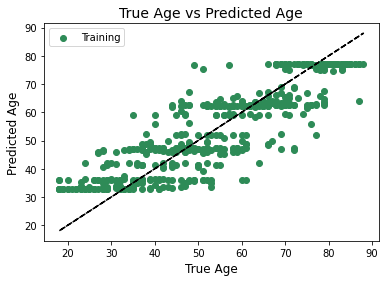

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = vols_normalised.T # features
y = meta_data_reg_test_500['age'].values.reshape(-1,1) # labels

# select random forrest model
random_forrest = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
random_forrest.fit(X, y.ravel())
y_pred = random_forrest.predict(X)

# plotting the results
plt.figure(figsize=(6,4))
plt.scatter(y, y_pred, color="seagreen")
plt.plot(y, y, color='k', linestyle="dashed")
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('True Age vs Predicted Age', fontsize=14)
plt.legend(['Training'])
plt.show()

Apply trained model to the test (100) dataset
Calculating tissue volumes from the test (100) dataset


Calculating Features: 100%|██████████| 100/100 [00:01<00:00, 63.20it/s]


Predicting the age of the test dataset using the Random Forrest regressor.
 
Test Results:
---------------------------------------------------------
Mean Absolute Error: 6.593092
Mean Squared Error: 70.846105
R2 Score: 0.812653
---------------------------------------------------------



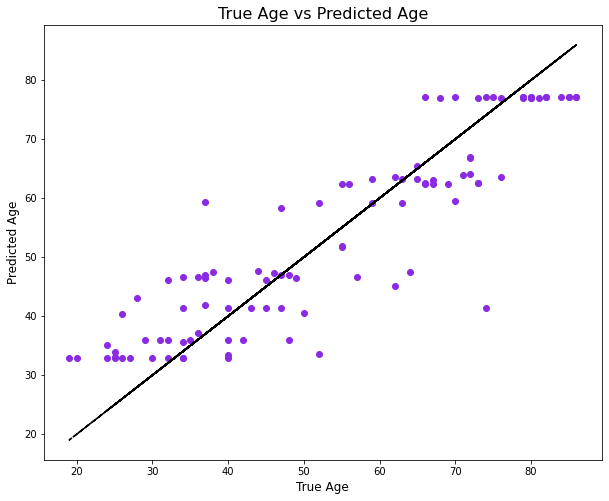

In [ ]:
from sklearn.metrics import *
model_dir = os.path.join(out_dir, 'unet_part_a')
model.load_state_dict(torch.load('output/unet_part_a/model.pt'))
model.to(device)
model.eval()

print('Apply trained model to the test (100) dataset')
# creating directory to save images
a_training_seg = os.path.join(out_dir, 'a_seg_test')
if not os.path.exists(a_training_seg):
    os.makedirs(a_training_seg)

dataloader_test_100 = torch.utils.data.DataLoader(dataset_test_100, batch_size=1, shuffle=False)

idx_test = 0
with torch.no_grad():
    # looping through the test dataset
    for sample_data in dataloader_test_100:
        # get the image and the segmentation
        image, segmentation, mask = sample_data['img'].to(device), sample_data['seg'].to(device), sample_data['msk'].to(device)
        # segmenting the image
        predicted_segmentation = model(image)
        predicted_segmentation = torch.argmax(predicted_segmentation, dim=1)

        # storing predicted segmentation
        sample = dataset_test_100.get_sample(idx_test)
        name = dataset_test_100.get_seg_name(idx_test)
        predicted_segmentation = sitk.GetImageFromArray(predicted_segmentation.cpu().squeeze().numpy().astype(np.uint8))
        predicted_segmentation.CopyInformation(sample['seg'])
        sitk.WriteImage(predicted_segmentation, os.path.join(a_training_seg, name))

        idx_test += 1  
    
print('Calculating tissue volumes from the test (100) dataset')
# making directory to saved test segmentation the results
seg_dir = './output/a_seg_test/'

# extracting data
meta_data_reg_test_100 = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test_100 = list(meta_data_reg_test_100['subject_id'])
files_reg_seg_test_100 = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test_100]


# matricies to store volume data
vols = np.zeros((3,len(files_reg_seg_test_100)))
vols_normalised = np.zeros((3,len(files_reg_seg_test_100)))

# iterating through the segmented test dataset
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test_100)), desc='Calculating Features')):
    # extracting the file name
    seg_filename = files_reg_seg_test_100[idx]
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)

        # calculate absolute volume of each tissue class
        background = np.sum(seg_array == 0) # 0 = background
        csf = np.sum(seg_array == 1) # 1 = csf
        gm = np.sum(seg_array == 2) # 2 = gm
        wm = np.sum(seg_array == 3) # 3 = wm

        # store absolute volumes in vols matrix
        vols[0, idx] = csf
        vols[1, idx] = gm
        vols[2, idx] = wm

        total_with_background = len(seg_array.flatten())
        total = np.sum(seg_array == 0)
        
        # storing relative volumes vols_normalised matrix
        vols_normalised[0, idx] = csf/(total_with_background-total)
        vols_normalised[1, idx] = gm/(total_with_background-total)
        vols_normalised[2, idx] = wm/(total_with_background-total)

print('Predicting the age of the test dataset using the Random Forrest regressor.')
# defining x and y for the regression
X = vols_normalised.T
y = meta_data_reg_test_100['age'].values.reshape(-1,1)

# predicting the age of the test dataset using the best regression model
y_pred = random_forrest.predict(X)

print(" ")
print("Test Results:")
print("---------------------------------------------------------")
# calculating the mean absolute error
mae = mean_absolute_error(y, y_pred)
print('Mean Absolute Error: {:.6f}'.format(mae))
# calculating the mean squared error
mse = mean_squared_error(y, y_pred)
print('Mean Squared Error: {:.6f}'.format(mse))
# calculating the r2 score
r2 = r2_score(y, y_pred)
print('R2 Score: {:.6f}'.format(r2))
print("---------------------------------------------------------")
print("")

plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, color="blueviolet")
plt.plot(y, y, color='k', linestyle="dashed")
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('True Age vs Predicted Age', fontsize=16)
plt.show()

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [ ]:
img_size = [64, 64, 64]
img_spacing = [1, 1, 1]

# Create the class to define and preprocess the regression dataset
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageAgeRegressionDataset(Dataset):
    """Dataset for image regression"""

    def __init__(self, file_list_img, file_list_msk, img_spacing, img_size, meta_data):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)
            age = meta_data['age'][idx]

            sample = {'img': img, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
      

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, item):
        sample = self.samples[item]
        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        age = torch.tensor(sample['age'], dtype = torch.float32)
        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

In [ ]:

import torch
import torch.nn as nn

class AgeRegressionCNN(nn.Module):
    def __init__(self):
        super(AgeRegressionCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv3d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm3d(512)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv6 = nn.Conv3d(512, 1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm3d(1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.pool6 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2 * 2 * 2 * 1024, 1024)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(1024, 1)
      
    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        x = self.relu6(self.bn6(self.conv6(x)))
        x = self.pool6(x)

        x = x.view(x.shape[0], 2 * 2 * 2 * 1024)
        
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * 4)

        if stride != 1 or in_channels != out_channels * 4:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * 4)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(256, 64),
            ResidualBlock(256, 64)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(256, 128, stride=2),
            ResidualBlock(512, 128),
            ResidualBlock(512, 128),
            ResidualBlock(512, 128)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(512, 256, stride=2),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256),
            ResidualBlock(1024, 256)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(1024, 512, stride=2),
            ResidualBlock(2048, 512),
            ResidualBlock(2048, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# Define the training loop for the CNN regressor model
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

model_dir = os.path.join(out_dir, 'AgeRegressor')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

validation_frequency = 1

def RegTraining(dataset, num_epochs, lr, batch_size, model_dir, weight_decay):
    # two fold cross validation
    kf = KFold(n_splits=2, shuffle=True, random_state=rnd_seed)
    kf.get_n_splits(dataset)

    fold_mse_train = []
    fold_mse_val = []
    fold_mae_train = []
    fold_mae_val = []
    
    # iterate over the folds
    for fold_idx, (train_index, val_index) in enumerate(kf.split(dataset)):
        
        print("Starting fold", (fold_idx+1))

        # Separate the data into training and validation sets

        train_sampler = SubsetRandomSampler(train_index)
        valid_sampler = SubsetRandomSampler(val_index)
        data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        data_loader_val = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    
        # define the model
        model =  ResNet50().to(device)

        # define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.1)

        # initialize the lists for storing the loss values
        loss_train_log = []
        
        mse_val_log = []
        epoch_val_log = []
        mae_train_log = []
        mae_val_log =[]
        epoch_val_log = []

        # define the loss function
        criterion = nn.MSELoss() 
        criterion_s = nn.L1Loss()

        for epoch in range(1, num_epochs+1):
            model.train()
            mse_loss = 0.0
            mae_loss = 0.0
            
            for batch_idx, data in enumerate(data_loader_train):
                images = data['img'] 
                labels = data['age'] 
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                output = model(images) # forward pass through model

                if len(output.shape) > 1:
                  output = output.squeeze(1)

                loss = criterion(output,labels)

                # update and save loss items
                loss.backward()
                optimizer.step()
                scheduler.step()
                mse_loss += loss.item()
                loss = criterion_s(output,labels)
                mae_loss += loss.item()
          
            loss_train_log.append(mse_loss/(batch_idx+1))
            mae_train_log.append(mae_loss/(batch_idx+1))
    
            if epoch % validation_frequency == 0 or epoch == 0:
                with torch.no_grad():
                    model.eval()

                    mse_loss_validation = 0.0
                    mae_loss_validation = 0.0

                    for batch_idx, data in enumerate(data_loader_val):
                        images = data['img'] 
                        labels = data['age'] 
                        images,labels = images.to(device), labels.to(device)
                        output = model(images)
                        if len(output.shape) > 1:
                          output = output.squeeze(1)

                        loss = criterion(output,labels)
                        mse_loss_validation+= loss.item()
                        loss = criterion_s(output,labels)
                        mae_loss_validation += loss.item()
            
            mse_val_log.append(mse_loss_validation/(batch_idx+1))
            mae_val_log.append(mae_loss_validation/(batch_idx+1))
            epoch_val_log.append(epoch)

            if epoch % validation_frequency == 0 or epoch == 0:
                print('Epoch: {} \tTraining MSE: {:.6f} \tTraining MAE: {:.6f} \tValidation MSE: {:.6f} \tValidation MAE: {:.6f}'.format(epoch, loss_train_log[-1], mae_train_log[-1], mse_val_log[-1], mae_val_log[-1]))
            else:
                print('Epoch: {} \tTraining MSE: {:.6f} \tTraining MAE: {:.6f}'.format(epoch, loss_train_log[-1], mae_train_log[-1]))

        fold_mse_train.append(loss_train_log)
        fold_mse_val.append(mse_val_log)
        fold_mae_train.append(mae_train_log)
        fold_mae_val.append(mae_val_log)

    print("Training has been completed.")

    torch.save(model.state_dict(), os.path.join(model_dir, model_name))
    print("Model has been saved")


    mean_loss_train = fold_mse_train
    mean_loss_val = fold_mse_val
    mean_MAE_train = fold_mae_train
    mean_MAE_val = fold_mae_val

    #print("mean_loss_train: ", mean_loss_train.shape)
    #print("mean_loss_val: ", mean_loss_val.shape)
    #print("mean_MAE_train: ", mean_MAE_train.shape)
    #print("mean_MAE_val: ", mean_MAE_val.shape)
    #print("")

    return mean_loss_train, mean_loss_val, mean_MAE_train, mae_val_log, mean_MAE_val


In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

# Load training + test data
dataset_train_age = ImageAgeRegressionDataset(files_seg_img_train, files_seg_msk_train, img_spacing, img_size, meta_data_reg_train)
dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)


Loading Data: 100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# Train different previously defined neural networks for regression 
# and plot the loss curves


model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = ResNet50().to(device)

model_name = 'ResNet50'
weight_decay = 1e-5
lr = 0.001
num_epochs = 40
batch_size = 16

mean_loss_train, mean_loss_val, mean_MAE_train, mae_val_log, mean_MAE_val = RegTraining(dataset_train_age, num_epochs, lr, batch_size, model_dir, weight_decay)



Starting fold 1
Epoch: 1 	Training MSE: 1059.698347 	Training MAE: 25.640286 	Validation MSE: 2523.212616 	Validation MAE: 47.409423
Epoch: 2 	Training MSE: 150.423413 	Training MAE: 9.850056 	Validation MSE: 279.258325 	Validation MAE: 13.897017
Epoch: 3 	Training MSE: 94.110364 	Training MAE: 8.119292 	Validation MSE: 76.198359 	Validation MAE: 6.908168
Epoch: 4 	Training MSE: 61.357960 	Training MAE: 6.311927 	Validation MSE: 70.634236 	Validation MAE: 6.530430
Epoch: 5 	Training MSE: 68.300629 	Training MAE: 6.365680 	Validation MSE: 62.733643 	Validation MAE: 6.256276
Epoch: 6 	Training MSE: 49.777850 	Training MAE: 5.745107 	Validation MSE: 57.034407 	Validation MAE: 5.902237
Epoch: 7 	Training MSE: 55.987192 	Training MAE: 6.245275 	Validation MSE: 57.551570 	Validation MAE: 5.897166
Epoch: 8 	Training MSE: 51.078804 	Training MAE: 5.733595 	Validation MSE: 58.007632 	Validation MAE: 5.963457
Epoch: 9 	Training MSE: 44.741874 	Training MAE: 5.262361 	Validation MSE: 57.161146 	V

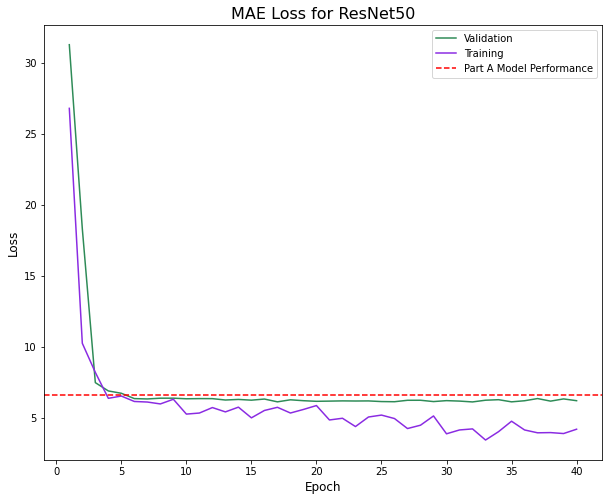

In [ ]:

plt.figure(figsize=(10,8))
plt.title('MAE Loss for ResNet50', fontsize=16)
#plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
plt.plot(range(1, num_epochs +1), np.mean(mean_MAE_val,axis=0), c='seagreen', label='Validation')
plt.plot(range(1, num_epochs +1), np.mean(mean_MAE_train,axis=0), c = 'blueviolet', label = 'Training')
plt.axhline(y = 6.59, color='r', linestyle='--', label = 'Part A Model Performance')
#plt.ylim(0, 15) 
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.show()

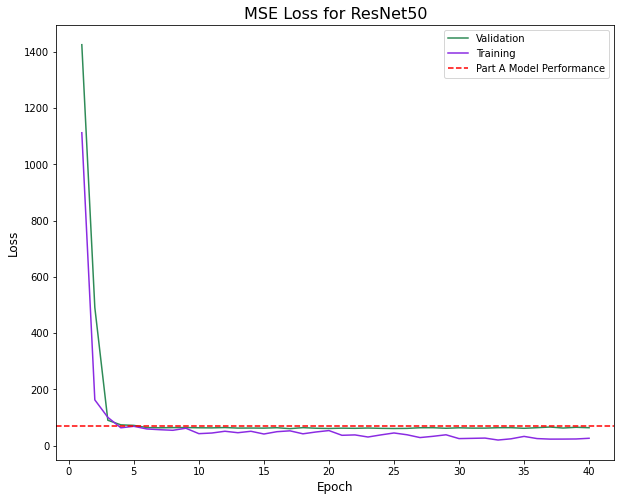

In [ ]:
plt.figure(figsize=(10,8))
plt.title('MSE Loss for ResNet50', fontsize=16)
#plt.plot(range(1, num_epochs + 1), loss_train_log_age, c='r', label='train')
plt.plot(range(1, num_epochs + 1), np.mean(mean_loss_val,axis=0), c='seagreen', label='Validation')
plt.plot(range(1, num_epochs +1),  np.mean(mean_loss_train, axis=0), c = 'blueviolet', label = 'Training')
plt.axhline(y = 70.84, color='r', linestyle='--', label = 'Part A Model Performance')
#plt.ylim(0, 15) 
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

START TESTING...
 
Test Results:
--------------------------
Mean Absolute Error: 6.210747509002686
Mean Squared Error: 60.347953586229885
R2 Score: 0.840414303313466

+ TESTING 	MSE_Loss: 60.347953586229885 	MAE_Loss: 6.210748

Finished TESTING.


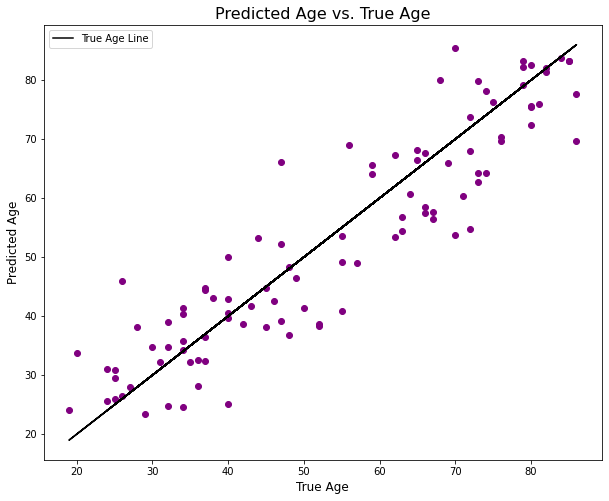

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
dataloader_test = torch.utils.data.DataLoader(dataset_test, 1, shuffle=False)

modelAgeRegressionTest = ResNet50()
#model_dir = os.path.join(out_dir, 'model_CNN')
modelAgeRegressionTest.load_state_dict(torch.load("./output/model/ResNet50"))
modelAgeRegressionTest.to(device)
modelAgeRegressionTest.eval()
    
print('START TESTING...')
absolute_error_list = []
predicted_age_list = []


with torch.no_grad():
    for idx, data_sample in enumerate(dataloader_test):
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        age = torch.tensor(meta_data_reg_test['age'].values[idx]).reshape(-1).to(device)
        age_prediction = modelAgeRegressionTest(img)
        predicted_age_list.append(age_prediction.item())
        # calculating loss
        absolute_error_list.append(F.l1_loss(age_prediction.squeeze(1), age).item())

y = meta_data_reg_test['age'].values.reshape(-1,1)

print(" ")
print("Test Results:")
print("--------------------------")
# calculate mean absolute error
mae = np.mean(absolute_error_list)
print(f"Mean Absolute Error: {mae}")
# calculate mean squared error
mse = np.mean(np.square(absolute_error_list))
print(f"Mean Squared Error: {mse}")
# calculate root mean squared error
r2s = r2_score(y, np.array(predicted_age_list))
print(f"R2 Score: {r2s}")

print("")
print('+ TESTING \tMSE_Loss: {} \tMAE_Loss: {:.6f}'.format(mse, mae))

print('\nFinished TESTING.')

# plotting the results
plt.figure(figsize=(10, 8))
plt.title('Predicted Age vs. True Age', fontsize=16)
plt.scatter(meta_data_reg_test['age'].values, predicted_age_list, c="purple")
plt.plot(meta_data_reg_test['age'].values, meta_data_reg_test['age'].values, c='k', label='True Age Line')
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.legend()
plt.show()